# 0. Self Introduction  
Deep Facial Verification using Siamese Neural Network
------------------------------------------------------------------------------------------------------------------------
#### ***Final project for partial fulfilment of course Data Science at SCDE of Jawaharlal Nehru Technological University Hyderabad.***
________________________________________________________________________________________________________________________


Project by: ***Narra SuryaKoushik Reddy***

E-Mail:  ***narrasuryakoushikreddy@gmail.com***

Project Report: Yet to compleate


# 1. Setup

## 1.1 Installing Dependencies'

only install this dependencies if you don't have them ***(I have already installed them in the beginning)***

In [1]:
# pip install tensorflow 

In [2]:
# pip install tensorflow-gpu

In [3]:
# pip install opencv-python

In [4]:
# pip install matplotlib

## 1.2 Import Dependencies

In [5]:
# import standard dependencies 
import cv2
import os
import random #optional but i imported it just in case
import numpy as np
from matplotlib import pyplot as plt

# importhing tensorflow dependencies 
# tensorflow functional API is lot more flexible for hard DL models like SNN
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten 
import tensorflow as tf

## 1.3 Set GPU Growth

**Using my GPU to avoid Out Of Memory (OOM) errors by setting GPU Memory Consumption Growth**

In [6]:
tf.test.is_gpu_available() # just making sure Tensorflow is detecting my GPU if not we need to setup manually(pip install tensorflow-gpu)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [7]:
# setting up GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures


In [8]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [9]:
# making the directories 
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2 Collect Positives and Anchors 

## 2.1 Untar Labelled Faces in the Wild Dataset 

***This data set is downloaded from the inter net and the link for that is in the Resources and References section***

In [10]:
# uncompressing TAR GZ Labelled faces in the Wild Dataset
!tar -xf lfw.tgz

In [11]:
# moving LFW images to the following repository data/negative

for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2 Collecting Positive and Anchor Samples

In [12]:
# import UUID library to generate unique image names
import uuid

In [13]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())) # checking if the UUID is working

'data\\anchor\\dc6ab08c-c3d5-11ed-be10-90e8685c3a0d.jpg'

In [14]:
# establishing a connection to the webcam
cap = cv2.VideoCapture(0) # i'm using inbuilt webcam (laptop cam) so it's '0'
while cap.isOpened():
    ret, frame = cap.read()
    
    #cutting down the frame to 250x250 pixels
    frame = frame[120:120+250, 200:200+250, :]
    
    # collectin anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'): # if we click 'a' it will collect a anchor
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame) # write out anchor image
    
    # collection positives
    if cv2.waitKey(1) & 0XFF == ord('p'): # if we click 'p' it will collect a positive
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame) # write out positive image
    
    # showing image back to screen
    cv2.imshow('capturing image', frame)
    
    # beaking greacefully (if we click 'q' the it should close the webcam window)
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

        
# release the webcam (if something went wrong we can reset)
cap.release()

# close the image show window/frame
cv2.destroyAllWindows()

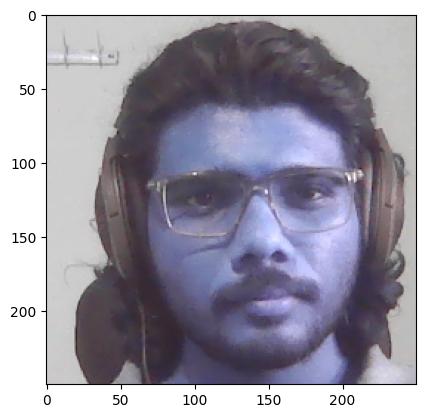

In [15]:
plt.imshow(frame)

## 2.3 Data Augmentation

In [16]:
def data_aug(img):
    img = tf.cast(img, tf.float32)
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        #img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(1,3))
        img = tf.image.stateless_random_flip_up_down(img, seed=(1,2))
        data.append(img)
    return data



In [17]:
import os
import uuid

In [20]:
img_path = os.path.join(ANC_PATH, '01edc364-c3da-11ed-980c-90e8685c3a0d.jpg')
img = cv2.imread(img_path)
if img is not None:
    augmented_images = data_aug(img)
    for image in augmented_images:
        cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())
else:
    print('Failed to read image')


In [19]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# 3. Images Loading and Preprocess

## 3.1 Get Image Directories

In [21]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [22]:
ANC_PATH+'\*.jpg' # testing

'data\\anchor\\*.jpg'

In [23]:
dir_test = anchor.as_numpy_iterator()  

In [24]:
abc = dir_test.next() # grabing a different image everytime we run

In [25]:
abc

b'data\\anchor\\01edc364-c3da-11ed-980c-90e8685c3a0d.jpg'

## 3.2 Preprocessing- Scale and Resize

In [26]:
def preprocess (file_path):
    byte_img = tf.io.read_file(file_path)  # reading the image
    img = tf.io.decode_jpeg(byte_img)      # loading the image
    img = tf.image.resize(img, (105,105))  # resizing the image to 105x105x3 same as in the research paper
    img = img / 255.0                      # scaling image to be b/w 0 and 1
    return img

In [27]:
img = preprocess(abc)

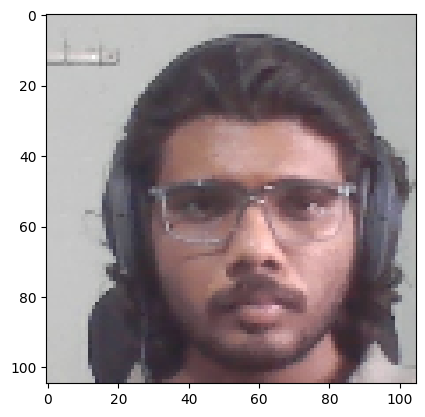

In [28]:
plt.imshow(img)

In [29]:
img.numpy().min()

0.13317771

In [30]:
img.numpy().max() # make sure it's not passing '1'

1.0

## 3.3 Create Labelled Dataset

In [31]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative)=> 0,0,0,0,0

In [32]:
tf.ones(len(anchor)) # effectively creating labelled positives

<tf.Tensor: shape=(300,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

In [33]:
tf.zeros(len(anchor)) # effectively creating labelled negatives

<tf.Tensor: shape=(300,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [34]:
# </ checking with an example
class_labels = tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))

In [35]:
iterator_labs = class_labels.as_numpy_iterator()

In [36]:
iterator_labs.next() # effectively looping through each lable in the class/>

0.0

In [37]:
# creating 2 different datasets for positives and negatives
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [38]:
sample = data.as_numpy_iterator()

In [39]:
example = sample.next() # as of now it is not shuffled, we have to compleate all positive iterators to reach negatives

In [40]:
example

(b'data\\anchor\\ec5b7441-c3d9-11ed-91fc-90e8685c3a0d.jpg',
 b'data\\positive\\561c0dbf-c3da-11ed-9692-90e8685c3a0d.jpg',
 1.0)

## 3.4 Train and Test Partitions 

In [41]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [42]:
result = preprocess_twin(*example) # '*' is to unpack the values of 'example'

In [43]:
result

(<tf.Tensor: shape=(105, 105, 3), dtype=float32, numpy=
 array([[[0.78431374, 0.78431374, 0.78431374],
         [0.784227  , 0.784227  , 0.784227  ],
         [0.78039217, 0.78039217, 0.78039217],
         ...,
         [0.72334266, 0.73902893, 0.73510736],
         [0.71773374, 0.73342   , 0.72949845],
         [0.7176471 , 0.73333335, 0.7294118 ]],
 
        [[0.78039217, 0.78039217, 0.78039217],
         [0.78039217, 0.78039217, 0.78039217],
         [0.78039217, 0.78039217, 0.78039217],
         ...,
         [0.72903824, 0.7363212 , 0.7326797 ],
         [0.72497004, 0.7327731 , 0.7288715 ],
         [0.7257703 , 0.7330532 , 0.7294118 ]],
 
        [[0.7809413 , 0.7809413 , 0.7809413 ],
         [0.7805189 , 0.7805189 , 0.7805189 ],
         [0.78313774, 0.78313774, 0.78313774],
         ...,
         [0.72351164, 0.7270597 , 0.72528565],
         [0.72156864, 0.729105  , 0.72533685],
         [0.7276377 , 0.7311858 , 0.7294118 ]],
 
        ...,
 
        [[0.5671602 , 0.55931705

In [44]:
result[0]

<tf.Tensor: shape=(105, 105, 3), dtype=float32, numpy=
array([[[0.78431374, 0.78431374, 0.78431374],
        [0.784227  , 0.784227  , 0.784227  ],
        [0.78039217, 0.78039217, 0.78039217],
        ...,
        [0.72334266, 0.73902893, 0.73510736],
        [0.71773374, 0.73342   , 0.72949845],
        [0.7176471 , 0.73333335, 0.7294118 ]],

       [[0.78039217, 0.78039217, 0.78039217],
        [0.78039217, 0.78039217, 0.78039217],
        [0.78039217, 0.78039217, 0.78039217],
        ...,
        [0.72903824, 0.7363212 , 0.7326797 ],
        [0.72497004, 0.7327731 , 0.7288715 ],
        [0.7257703 , 0.7330532 , 0.7294118 ]],

       [[0.7809413 , 0.7809413 , 0.7809413 ],
        [0.7805189 , 0.7805189 , 0.7805189 ],
        [0.78313774, 0.78313774, 0.78313774],
        ...,
        [0.72351164, 0.7270597 , 0.72528565],
        [0.72156864, 0.729105  , 0.72533685],
        [0.7276377 , 0.7311858 , 0.7294118 ]],

       ...,

       [[0.5671602 , 0.55931705, 0.57108176],
        [0.58

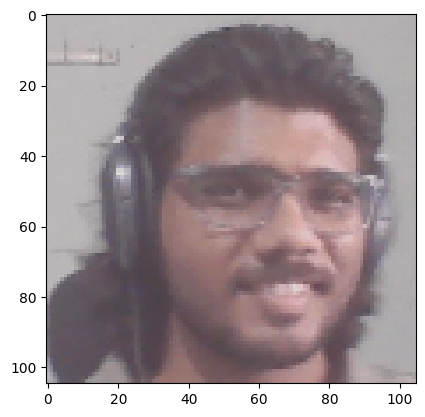

In [45]:
plt.imshow(result[1])

In [46]:
result[2]

1.0

In [47]:
# building dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024) # shuffling the data

In [48]:
data

<ShuffleDataset shapes: ((105, 105, None), (105, 105, None), ()), types: (tf.float32, tf.float32, tf.float32)>

In [49]:
data.as_numpy_iterator()

In [50]:
samples = data.as_numpy_iterator()

In [51]:
samples.next()

(array([[[0.78039217, 0.78039217, 0.78039217],
         [0.7767507 , 0.7767507 , 0.7767507 ],
         [0.7825397 , 0.7825397 , 0.7825397 ],
         ...,
         [0.72511667, 0.7372549 , 0.73333335],
         [0.71651995, 0.7322062 , 0.72828466],
         [0.7110177 , 0.726704  , 0.73062557]],
 
        [[0.7791783 , 0.7791783 , 0.7791783 ],
         [0.7767307 , 0.7767307 , 0.7767307 ],
         [0.78039217, 0.78039217, 0.78039217],
         ...,
         [0.7215019 , 0.73333335, 0.72885156],
         [0.71766704, 0.7333133 , 0.72935176],
         [0.7176471 , 0.73333335, 0.7294118 ]],
 
        [[0.7791783 , 0.7791783 , 0.7791783 ],
         [0.77811795, 0.77811795, 0.77811795],
         [0.78039217, 0.78039217, 0.78039217],
         ...,
         [0.72334266, 0.7311858 , 0.7194211 ],
         [0.71792716, 0.73470056, 0.7252768 ],
         [0.7152083 , 0.73089457, 0.726973  ]],
 
        ...,
 
        [[0.7713352 , 0.7713352 , 0.7713352 ],
         [0.7764706 , 0.7764706 , 0.77647

In [52]:
samp = samples.next()

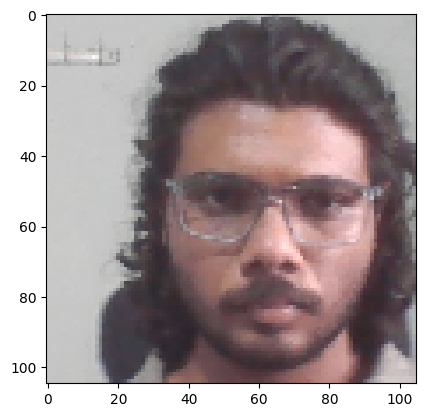

In [53]:
plt.imshow(samp[0])

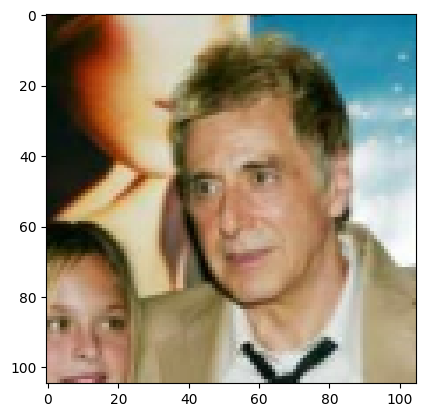

In [54]:
plt.imshow(samp[1])

In [55]:
samp[2]

0.0

In [56]:
round(len(data)*.7)

420

In [57]:
data

<ShuffleDataset shapes: ((105, 105, None), (105, 105, None), ()), types: (tf.float32, tf.float32, tf.float32)>

In [58]:
# creating training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [59]:
train_data

<PrefetchDataset shapes: ((None, 105, 105, None), (None, 105, 105, None), (None,)), types: (tf.float32, tf.float32, tf.float32)>

In [60]:
train_samples = train_data.as_numpy_iterator()

In [61]:
train_sample = train_samples.next()

In [62]:
len(train_sample[0])

16

In [63]:
# creating testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering 

# 4.1 Build Embedding Layer

In [64]:
def make_embedding():
    inp = Input(shape=(105, 105, 3), name='input_image')
    
    # 1st block
    c1 = Conv2D(64,(10,10), activation = 'relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # 2nd block
    c2 = Conv2D(128, (7,7), activation = 'relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding= 'same')(c2)
    
    # 3rd block
    c3 = Conv2D(128, (4,4), activation = 'relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding= 'same')(c3)
    
    # 4th / final embedding block
    c4 = Conv2D(256, (4,4), activation= 'relu')(m3)
    f1 = Flatten()(c4)                              # flatenning the output
    d1 = Dense(4096, activation= 'sigmoid')(f1)     # making the flatten layer to a dense layer
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [65]:
embedding = make_embedding()

In [66]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 105, 105, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

## 4.2 Build Distance Layer

In [67]:
class L1Dist(Layer):               # siamese L1 distance class 
     
    def __init__(self, **kwargs):  # inheritance 
        super().__init__()
        
    # similarity calculation     
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [68]:
l1 = L1Dist()

In [69]:
l1

## 4.3 Make Siamese Model

In [70]:
input_image = Input(name= 'input_img', shape= (105,105,3)) 
validation_image = Input(name= 'validation_img', shape = (105,105,3))

In [71]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [72]:
inp_embedding

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [73]:
val_embedding

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [74]:
siamese_layer = L1Dist()

In [75]:
distances = siamese_layer(inp_embedding, val_embedding)

In [76]:
classsifier = Dense(1, activation='sigmoid')(distances)

In [77]:
classsifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_1')>

In [78]:
def make_siamese_model():
    
    input_image = Input(name= 'input_img', shape= (105,105,3)) # anchor image in the network
    validation_image = Input(name= 'validation_img', shape = (105,105,3)) # validation image in the network
    
    
    # combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # clasification layer
    classsifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs= classsifier, name='SiameseNetwork')

In [79]:
siamese_model = make_siamese_model()

In [80]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[2][0]     

# 5. Training Model

## 5.1 Setup Loss and Optimizer

In [81]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [82]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [83]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model= siamese_model)

## 5.3 Build Train Step Function 

In [84]:
test_batch = train_data.as_numpy_iterator()

In [85]:
batch_1 = test_batch.next()

In [86]:
len(batch_1)

3

In [87]:
batch_1 = test_batch.next()

In [88]:
X = batch_1[:2]

In [89]:
np.array(X).shape

(2, 16, 105, 105, 3)

In [90]:
Y = batch_1[2]

In [91]:
Y

array([0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1.],
      dtype=float32)

In [92]:
@tf.function
def train_step(batch):
    
    with tf.GradientTape() as tape:
        
        X = batch[:2] # get anchor and positive/negative image
        
        Y = batch[2] # get label
        
        
        # forwoard pass
        yhat = siamese_model(X, training= True)
        
        # calculate losss
        loss = binary_cross_loss(Y, yhat)
    print(loss)
        
    # calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad,siamese_model.trainable_variables))
    
    return loss

    pass

## 5.4 Build Training Loop

In [93]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [94]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [95]:
EPOCHS = 50

In [96]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 24s 451ms/step
0.018392136 0.75117373 1.0

 Epoch 2/50
27/27 [==============================] - 11s 403ms/step
8.3728424e-05 0.98536587 1.0

 Epoch 3/50
27/27 [==============================] - 10s 368ms/step
0.0040121814 0.980198 1.0

 Epoch 4/50
27/27 [==============================] - 10s 368ms/step
7.3604955e-05 0.99065423 1.0

 Epoch 5/50
27/27 [==============================] - 10s 361ms/step
0.040654175 0.9858491 1.0

 Epoch 6/50
27/27 [==============================] - 10s 358ms/step
0.000636031 0.99512196 1.0

 Epoch 7/50
27/27 [==============================] - 10s 359ms/step
6.1533414e-05 0.9953488 1.0

 Epoch 8/50
27/27 [==============================] - 10s 355ms/step
0.017002404 1.0 1.0

 Epoch 9/50
27/27 [==============================] - 10s 360ms/step
8.990613e-05 

# 6. Evaluate Model

## 6.1 Import Metrics

In [97]:
# import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions 

In [98]:
# get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [99]:
test_var = test_data.as_numpy_iterator().next()

In [100]:
test_var[2]

array([0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
      dtype=float32)

In [101]:
y_true

array([0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1.],
      dtype=float32)

In [102]:
# predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

array([[3.6457812e-09],
       [2.2554898e-09],
       [2.2173548e-10],
       [1.0000000e+00],
       [1.0000000e+00],
       [2.0097275e-09],
       [9.9999237e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.2133003e-07],
       [9.9999952e-01],
       [1.2995418e-09],
       [1.8667521e-09],
       [9.0480752e-09],
       [8.7294957e-08],
       [9.9997020e-01]], dtype=float32)

In [109]:
# post processing the results
res = []
for prediction in y_hat:
    if prediction > 0.9:
        res.append(1)
    else:
        res.append(0)
res

[0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1]

In [110]:
y_true

array([0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1.],
      dtype=float32)

## 6.3 Calculate Metrics

In [111]:
# creating a metric object with Recall
m = Recall()

# calculating the recall value
m.update_state(y_true, y_hat)

# recall result
m.result().numpy()

1.0

In [112]:
# creating a metric object with Precision
m = Precision()

# calculating the recall value
m.update_state(y_true, y_hat)

# recall result
m.result().numpy()

1.0

## 6.4 Visualizing results  

<function matplotlib.pyplot.show(close=None, block=None)>

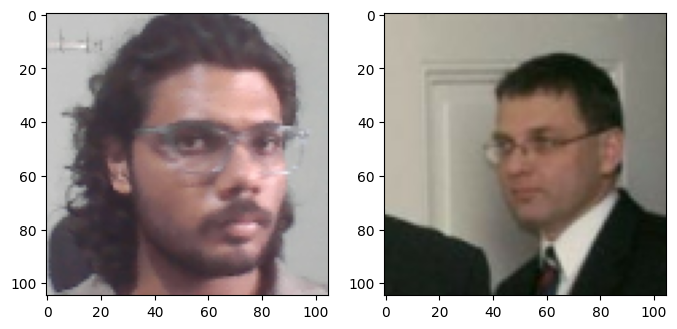

In [116]:
plt.figure(figsize=(8,5))  # plot size

# first sub plot
plt.subplot(1,2,1)
plt.imshow(test_input[9])   # res indexing image references

# second sub plot
plt.subplot(1,2,2)
plt.imshow(test_val[9])     # y_true indexing image references 

# rendering 
plt.show

# 7. Save Model

In [117]:
# save weight
siamese_model.save('SiameseModel.h5')

In [118]:
# reload model
model = tf.keras.models.load_model('SiameseModel.h5',
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [119]:
# make predictions with reloaded model
model.predict([test_input, test_val])

array([[3.6457812e-09],
       [2.2554898e-09],
       [2.2173548e-10],
       [1.0000000e+00],
       [1.0000000e+00],
       [2.0097275e-09],
       [9.9999237e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.2133003e-07],
       [9.9999952e-01],
       [1.2995418e-09],
       [1.8667521e-09],
       [9.0480752e-09],
       [8.7294957e-08],
       [9.9997020e-01]], dtype=float32)

In [120]:
model.summary() # model summary

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_3 (L1Dist)              (None, 4096)         0           embedding[0][0]     

# 8. Real Time Test

## 8.1 Verification Function

- I have created 1 main folder 'application_data' and 2 sub folders 'input_image' and 'verification_images inside 'application_data'

- I have also copied 50 positive samples from 'POS_PATH' to 'verification_images' 

- We will save our live input image to 'input_image' folder and compare it with our positive samples in 'verification_images' 

- For better accuracy we will only verify the input image when it is matched more then 60% of the images in 'verification_images'

In [121]:
len(os.listdir(os.path.join('application_data', 'verification_images')))

304

In [124]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [134]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
 

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.7, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

True
False
False
False
True
